# NATURAL LANGUAGE PROCESSING APPLICATIONS

In this notebook we will take a look at some indicative applications of natural language processing. We will cover content from [`nlp.py`](https://github.com/aimacode/aima-python/blob/master/nlp.py) and [`text.py`](https://github.com/aimacode/aima-python/blob/master/text.py), for chapters 22 and 23 of Stuart Russel's and Peter Norvig's book [*Artificial Intelligence: A Modern Approach*](http://aima.cs.berkeley.edu/).

## CONTENTS

* Language Recognition
* Author Recognition
* The Federalist Papers

# LANGUAGE RECOGNITION

A very useful application of text models (you can read more on them on the [`text notebook`](https://github.com/aimacode/aima-python/blob/master/text.ipynb)) is categorizing text into a language. In fact, with enough data we can categorize correctly mostly any text. That is because different languages have certain characteristics that set them apart. For example, in German it is very usual for 'c' to be followed by 'h' while in English we see 't' followed by 'h' a lot.

Here we will build an application to categorize sentences in either English or German.

First we need to build our dataset. We will take as input text in English and in German and we will extract n-gram character models (in this case, *bigrams* for n=2). For English, we will use *Flatland* by Edwin Abbott and for German *Faust* by Goethe.

Let's build our text models for each language, which will hold the probability of each bigram occuring in the text.

In [1]:
from utils import open_data
from text import *

flatland = open_data("EN-text/flatland.txt").read()
wordseq = words(flatland)

P_flatland = NgramCharModel(2, wordseq)

faust = open_data("GE-text/faust.txt").read()
wordseq = words(faust)

P_faust = NgramCharModel(2, wordseq)

We can use this information to build a *Naive Bayes Classifier* that will be used to categorize sentences (you can read more on Naive Bayes on the [`learning notebook`](https://github.com/aimacode/aima-python/blob/master/learning.ipynb)). The classifier will take as input the probability distribution of bigrams and given a list of bigrams (extracted from the sentence to be classified), it will calculate the probability of the example/sentence coming from each language and pick the maximum.

Let's build our classifier, with the assumption that English is as probable as German (the input is a dictionary with values the text models and keys the tuple `language, probability`):

In [2]:
from learning import NaiveBayesLearner

dist = {('English', 1): P_flatland, ('German', 1): P_faust}

nBS = NaiveBayesLearner(dist, simple=True)

Now we need to write a function that takes as input a sentence, breaks it into a list of bigrams and classifies it with the naive bayes classifier from above.

Once we get the text model for the sentence, we need to unravel it. The text models show the probability of each bigram, but the classifier can't handle that extra data. It requires a simple *list* of bigrams. So, if the text model shows that a bigram appears three times, we need to add it three times in the list. Since the text model stores the n-gram information in a dictionary (with the key being the n-gram and the value the number of times the n-gram appears) we need to iterate through the items of the dictionary and manually add them to the list of n-grams.

In [3]:
def recognize(sentence, nBS, n):
    sentence = sentence.lower()
    wordseq = words(sentence)
    
    P_sentence = NgramCharModel(n, wordseq)
    
    ngrams = []
    for b, p in P_sentence.dictionary.items():
        ngrams += [b]*p
    
    print(ngrams)
    
    return nBS(ngrams)

Now we can start categorizing sentences.

In [4]:
recognize("Ich bin ein platz", nBS, 2)

[(' ', 'i'), ('i', 'c'), ('c', 'h'), (' ', 'b'), ('b', 'i'), ('i', 'n'), ('i', 'n'), (' ', 'e'), ('e', 'i'), (' ', 'p'), ('p', 'l'), ('l', 'a'), ('a', 't'), ('t', 'z')]


'German'

In [5]:
recognize("Turtles fly high", nBS, 2)

[(' ', 't'), ('t', 'u'), ('u', 'r'), ('r', 't'), ('t', 'l'), ('l', 'e'), ('e', 's'), (' ', 'f'), ('f', 'l'), ('l', 'y'), (' ', 'h'), ('h', 'i'), ('i', 'g'), ('g', 'h')]


'English'

In [6]:
recognize("Der pelikan ist hier", nBS, 2)

[(' ', 'd'), ('d', 'e'), ('e', 'r'), ('e', 'r'), (' ', 'p'), ('p', 'e'), ('e', 'l'), ('l', 'i'), ('i', 'k'), ('k', 'a'), ('a', 'n'), (' ', 'i'), ('i', 's'), ('s', 't'), (' ', 'h'), ('h', 'i'), ('i', 'e')]


'German'

In [7]:
recognize("And thus the wizard spoke", nBS, 2)

[(' ', 'a'), ('a', 'n'), ('n', 'd'), (' ', 't'), (' ', 't'), ('t', 'h'), ('t', 'h'), ('h', 'u'), ('u', 's'), ('h', 'e'), (' ', 'w'), ('w', 'i'), ('i', 'z'), ('z', 'a'), ('a', 'r'), ('r', 'd'), (' ', 's'), ('s', 'p'), ('p', 'o'), ('o', 'k'), ('k', 'e')]


'English'

You can add more languages if you want, the algorithm works for as many as you like! Also, you can play around with *n*. Here we used 2, but other numbers work too (even though 2 suffices). The algorithm is not perfect, but it has high accuracy even for small samples like the ones we used. That is because English and German are very different languages. The closer together languages are (for example, Norwegian and Swedish share a lot of common ground) the lower the accuracy of the classifier.

## AUTHOR RECOGNITION

Another similar application to language recognition is recognizing who is more likely to have written a sentence, given text written by them. Here we will try and predict text from Edwin Abbott and Jane Austen. They wrote *Flatland* and *Pride and Prejudice* respectively.

We are optimistic we can determine who wrote what based on the fact that Abbott wrote his novella on much later date than Austen, which means there will be linguistic differences between the two works. Indeed, *Flatland* uses more modern and direct language while *Pride and Prejudice* is written in a more archaic tone containing more sophisticated wording.

Similarly with Language Recognition, we will first import the two datasets. This time though we are not looking for connections between characters, since that wouldn't give that great results. Why? Because both authors use English and English follows a set of patterns, as we show earlier. Trying to determine authorship based on this patterns would not be very efficient.

Instead, we will abstract our querying to a higher level. We will use words instead of characters. That way we can more accurately pick at the differences between their writing style and thus have a better chance at guessing the correct author.

Let's go right ahead and import our data:

In [8]:
from utils import open_data
from text import *

flatland = open_data("EN-text/flatland.txt").read()
wordseq = words(flatland)

P_Abbott = UnigramWordModel(wordseq, 5)

pride = open_data("EN-text/pride.txt").read()
wordseq = words(pride)

P_Austen = UnigramWordModel(wordseq, 5)

This time we set the `default` parameter of the model to 5, instead of 0. If we leave it at 0, then when we get a sentence containing a word we have not seen from that particular author, the chance of that sentence coming from that author is exactly 0 (since to get the probability, we multiply all the separate probabilities; if one is 0 then the result is also 0). To avoid that, we tell the model to add 5 to the count of all the words that appear.

Next we will build the Naive Bayes Classifier:

In [9]:
from learning import NaiveBayesLearner

dist = {('Abbott', 1): P_Abbott, ('Austen', 1): P_Austen}

nBS = NaiveBayesLearner(dist, simple=True)

Now that we have build our classifier, we will start classifying. First, we need to convert the given sentence to the format the classifier needs. That is, a list of words.

In [10]:
def recognize(sentence, nBS):
    sentence = sentence.lower()
    sentence_words = words(sentence)
    
    return nBS(sentence_words)

First we will input a sentence that is something Abbott would write. Note the use of square and the simpler language.

In [11]:
recognize("the square is mad", nBS)

'Abbott'

The classifier correctly guessed Abbott.

Next we will input a more sophisticated sentence, similar to the style of Austen.

In [12]:
recognize("a most peculiar acquaintance", nBS)

'Austen'

The classifier guessed correctly again.

You can try more sentences on your own. Unfortunately though, since the datasets are pretty small, chances are the guesses will not always be correct.

## THE FEDERALIST PAPERS

Let's now take a look at a harder problem, classifying the authors of the [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers). The *Federalist Papers* are a series of papers written by Alexander Hamilton, James Madison and John Jay towards establishing the United States Constitution.

What is interesting about these papers is that they were all written under a pseudonym, "Publius", to keep the identity of the authors a secret. Only after Hamilton's death, when a list was found written by him detailing the authorship of the papers, did the rest of the world learn what papers each of the authors wrote. After the list was published, Madison chimed in to make a couple of corrections: Hamilton, Madison said, hastily wrote down the list and assigned some papers to the wrong author!

Here we will try and find out who really wrote these mysterious papers.

To solve this we will learn from the undisputed papers to predict the disputed ones. First, let's read the texts from the file:

In [13]:
from utils import open_data
from text import *

federalist = open_data("EN-text/federalist.txt").read()

Let's see how the text looks. We will print the first 500 characters:

In [14]:
federalist[:500]

'The Project Gutenberg EBook of The Federalist Papers, by \nAlexander Hamilton and John Jay and James Madison\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.net\n\n\nTitle: The Federalist Papers\n\nAuthor: Alexander Hamilton\n        John Jay\n        James Madison\n\nPosting Date: December 12, 2011 [EBook #18]'

It seems that the text file opens with a license agreement, hardly useful in our case. In fact, the license spans 113 words, while there is also a licensing agreement at the end of the file, which spans 3098 words. We need to remove them. To do so, we will first convert the text into words, to make our lives easier.

In [15]:
wordseq = words(federalist)
wordseq = wordseq[114:-3098]

Let's now take a look at the first 100 words:

In [16]:
' '.join(wordseq[:100])

'federalist no 1 general introduction for the independent journal hamilton to the people of the state of new york after an unequivocal experience of the inefficacy of the subsisting federal government you are called upon to deliberate on a new constitution for the united states of america the subject speaks its own importance comprehending in its consequences nothing less than the existence of the union the safety and welfare of the parts of which it is composed the fate of an empire in many respects the most interesting in the world it has been frequently remarked that it seems to'

Much better. The text is now free from punctuations and in lower case.

As with any Natural Language Processing problem, it is prudent to do some text pre-processing and clean our data before we start building our model. Remember that all the papers are signed as 'Publius', so we can safely remove that word, since it doesn't give us any information as to the real author.

NOTE: Since we are only removing a single word from each paper, this step can be skipped. We add it here to show that processing the data in our hands is something we should always be considering. Oftentimes pre-processing the data in just the right way is the difference between a robust model and a flimsy one.

In [17]:
wordseq = [w for w in wordseq if w != 'publius']

Now we have to separate the text from a block of words into papers and assign them to their authors. We can see that each paper starts with the word 'federalist', so we will split the text on that word.

Finally, to keep the implementation intuitive, we add a `None` object at the start of the `papers` list to make the list index match up with the paper numbering (for example, `papers[5]` now corresponds to paper no. 5 instead of the paper no.6 in the 0-indexed Python).

In [18]:
import re

papers = re.split(r'federalist\s', ' '.join(wordseq))
papers = [p for p in papers if p not in ['', ' ']]
papers = [None] + papers

After getting the words, we need the root form rather than the original word. For eg. the words support, supportive, supporting have the root word support. It is better to have a single root word for multiple different words with similar meaning. It reduces the dimension of data. There are many stemming algorithms in NLP, popular ones being the porter stemmer and snowball stemmer. <br>
Here we'll implement a simple stemmer which truncates the suffixes like 'ive', 'ed', 'tion' & 'ing' for demonstartion purposes.

In [19]:
def stemmer(word):
    if word.endswith(('ing', 'ive')):
        word = word[:-3]
    elif word.endswith('ed'):
        word = word[:-2]
    elif word.endswith('tion'):
        word = word[:-4]
    return word


In [20]:
stemmed_papers = [None] + list(map(lambda paper: (' '.join(list(map(stemmer, paper.split())))), papers[1:]))

The disputed papers are the papers from 49 to 58, from 18 to 20 and paper 64. We want to leave these papers unassigned. Also, note that there are two versions of paper 70; both from Hamilton.

In [21]:
disputed = list(range(49, 58+1)) + [18, 19, 20, 64]
jay, madison, hamilton = [], [], []
for i, p in enumerate(papers):
    if i in disputed or i == 0:
        continue
    
    if 'jay' in p:
        jay.append(p)
    elif 'madison' in p:
        madison.append(p)
    else:
        hamilton.append(p)

len(jay), len(madison), len(hamilton)

(4, 16, 52)

Let's take a look at the common words used by them. <br>
We'll plot a word cloud. It is an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency.

In [22]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

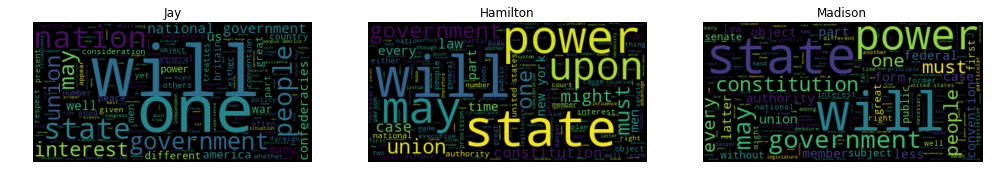

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,7))
wc = WordCloud().generate(' '.join(jay))
ax1.imshow(wc, interpolation='bilinear')
ax1.set_title('Jay')
ax1.axis("off");
wc = WordCloud().generate(' '.join(hamilton))
ax2.imshow(wc, interpolation='bilinear')
ax2.set_title('Hamilton')
ax2.axis("off");
wc = WordCloud().generate(' '.join(madison))
ax3.imshow(wc, interpolation='bilinear')
ax3.set_title('Madison')
ax3.axis("off");

They all have common words like state, will & government. Hamilton seems to use the words like might, may a lot. Word clouds reveal some sort of sentiments if analyzed properly.

As we can see, from the undisputed papers Jay wrote 4, Madison 17 and Hamilton 51 (+1 duplicate). Let's now build our word models. The Unigram Word Model again will come in handy.

In [24]:
hamilton = ''.join(hamilton)
hamilton_words = words(hamilton)
P_hamilton = UnigramWordModel(hamilton_words, default=1)

madison = ''.join(madison)
madison_words = words(madison)
P_madison = UnigramWordModel(madison_words, default=1)

jay = ''.join(jay)
jay_words = words(jay)
P_jay = UnigramWordModel(jay_words, default=1)

Now it is time to build our new Naive Bayes Learner. It is very similar to the one found in `learning.py`, but with an important difference: it doesn't classify an example, but instead returns the probability of the example belonging to each class. This will allow us to not only see to whom a paper belongs to, but also the probability of authorship as well. 
We will build two versions of Learners, one will multiply probabilities as is and other will add the logarithms of them.

Finally, since we are dealing with long text and the string of probability multiplications is long, we will end up with the results being rounded to 0 due to floating point underflow. To work around this problem we will use the built-in Python library `decimal`, which allows as to set decimal precision to much larger than normal.

Note that the logarithmic learner will compute a negative likelihood since the logarithm of values less than 1 will be negative.
Thus, the author with the lesser magnitude of proportion is more likely to have written that paper.



In [25]:
import random
import decimal
import math
from decimal import Decimal

decimal.getcontext().prec = 100

def precise_product(numbers):
    result = 1
    for x in numbers:
        result *= Decimal(x)
    return result

def log_product(numbers):
    result = 0.0
    for x in numbers:
        result += math.log(x)
    return result

def NaiveBayesLearner(dist):
    """A simple naive bayes classifier that takes as input a dictionary of
    Counter distributions and can then be used to find the probability
    of a given item belonging to each class.
    The input dictionary is in the following form:
        ClassName: Counter"""
    attr_dist = {c_name: count_prob for c_name, count_prob in dist.items()}

    def predict(example):
        """Predict the probabilities for each class."""
        def class_prob(target, e):
            attr = attr_dist[target]
            return precise_product([attr[a] for a in e])

        pred = {t: class_prob(t, example) for t in dist.keys()}

        total = sum(pred.values())
        for k, v in pred.items():
            pred[k] = v / total

        return pred

    return predict

def NaiveBayesLearnerLog(dist):
    """A simple naive bayes classifier that takes as input a dictionary of
    Counter distributions and can then be used to find the probability
    of a given item belonging to each class. It will compute the likelihood by adding the logarithms of probabilities.
    The input dictionary is in the following form:
        ClassName: Counter"""
    attr_dist = {c_name: count_prob for c_name, count_prob in dist.items()}

    def predict(example):
        """Predict the probabilities for each class."""
        def class_prob(target, e):
            attr = attr_dist[target]
            return log_product([attr[a] for a in e])

        pred = {t: class_prob(t, example) for t in dist.keys()}

        total = -sum(pred.values())
        for k, v in pred.items():
            pred[k] = v/total

        return pred

    return predict



Next we will build our Learner. Note that even though Hamilton wrote the most papers, that doesn't make it more probable that he wrote the rest, so all the class probabilities will be equal. We can change them if we have some external knowledge, which for this tutorial we do not have.

In [29]:
dist = {('Madison', 1): P_madison, ('Hamilton', 1): P_hamilton, ('Jay', 1): P_jay}
nBS = NaiveBayesLearner(dist)
nBSL = NaiveBayesLearnerLog(dist)

As usual, the `recognize` function will take as input a string and after removing capitalization and splitting it into words, will feed it into the Naive Bayes Classifier.

In [30]:
def recognize(sentence, nBS):
    return nBS(words(sentence.lower()))

Now we can start predicting the disputed papers:

In [31]:
print('\nStraightforward Naive Bayes Learner\n')
for d in disputed:
    probs = recognize(papers[d], nBS)
    results = ['{}: {:.4f}'.format(name, probs[(name, 1)]) for name in 'Hamilton Madison Jay'.split()]
    print('Paper No. {}: {}'.format(d, ' '.join(results)))

print('\nLogarithmic Naive Bayes Learner\n')
for d in disputed:
    probs = recognize(papers[d], nBSL)
    results = ['{}: {:.6f}'.format(name, probs[(name, 1)]) for name in 'Hamilton Madison Jay'.split()]
    print('Paper No. {}: {}'.format(d, ' '.join(results)))




Straightforward Naive Bayes Learner

Paper No. 49: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 50: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 51: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 52: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 53: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 54: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 55: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 56: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 57: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 58: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 18: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 19: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 20: Hamilton: 0.0000 Madison: 1.0000 Jay: 0.0000
Paper No. 64: Hamilton: 1.0000 Madison: 0.0000 Jay: 0.0000

Logarithmic Naive Bayes Learner

Paper No. 49: Hamilton: -0.330591 Madison: -0.327717 Jay: -0.341692
Paper No. 50: Hamilton: -0.333119 

We can see that both learners classify the papers identically. Because of underflow in the straightforward learner, only one author remains with a positive value. The log learner is more accurate with marginal differences between all the authors. 

This is a simple approach to the problem and thankfully researchers are fairly certain that papers 49-58 were all written by Madison, while 18-20 were written in collaboration between Hamilton and Madison, with Madison being credited for most of the work. Our classifier is not that far off. It correctly identifies the papers written by Madison, even the ones in collaboration with Hamilton.

Unfortunately, it misses paper 64. Consensus is that the paper was written by John Jay, while our classifier believes it was written by Hamilton. The classifier is wrong there because it does not have much information on Jay's writing; only 4 papers. This is one of the problems with using unbalanced datasets such as this one, where information on some classes is sparser than information on the rest. To avoid this, we can add more writings for Jay and Madison to end up with an equal amount of data for each author.